In [1]:
# %qtconsole

In [2]:
# imports
from pandas_profiling import ProfileReport
import sweetviz as sv
import seaborn as sns
import pickle as pkl
import math
# 
from moduleDatabase import DatabaseMethods
from moduleUtilities import UtilityMethods
from modulePreProcessing import TransformationMethods, FeatureMethods
from moduleModelTraining import TrainingMethods
from moduleMetrics import MetricsMethods

In [3]:
# class instances
db = DatabaseMethods()
ut = UtilityMethods()
tf = TransformationMethods()
fm = FeatureMethods()
train = TrainingMethods()
evaluate = MetricsMethods()

In [4]:
# connect to db and fetch data
df = db.fetch("SELECT * FROM v9")
df.head()

,userId,gsId,gsStartTime,age,sex,education,laptop_usage,smartphone_usage,smoking,family_med_history,...,mmse_pre_binary_binned,moca_pre_init,moca_pre_severity_binned,moca_pre_binary_binned,mmse_post_init,mmse_post_severity_binned,mmse_post_binary_binned,moca_post_init,moca_post_severity_binned,moca_post_binary_binned
0,23,18245,1560929400,70,1,4,0,0,0,1,...,1,19,2,1,21,2,1,23,2,1
1,6,76067,1555499640,61,1,4,1,3,0,1,...,2,24,2,1,29,3,2,26,3,2
2,8,79781,1557928260,83,1,5,1,1,0,0,...,2,25,2,1,25,3,2,22,2,1
3,32,180144,1557315840,71,1,2,0,4,0,0,...,2,27,3,2,29,3,2,25,2,1
4,24,209758,1560933840,75,1,2,0,0,0,1,...,1,21,2,1,18,2,1,19,2,1


In [5]:
# End of ETL
# Start of EDA

In [6]:
# Pandas Profiling
# profile = ProfileReport(df, title="Data Profile Rerort", explorative=True)
# profile.to_notebook_iframe()

# # Sweetvix
# my_report = sv.analyze(df)
# my_report.show_html()

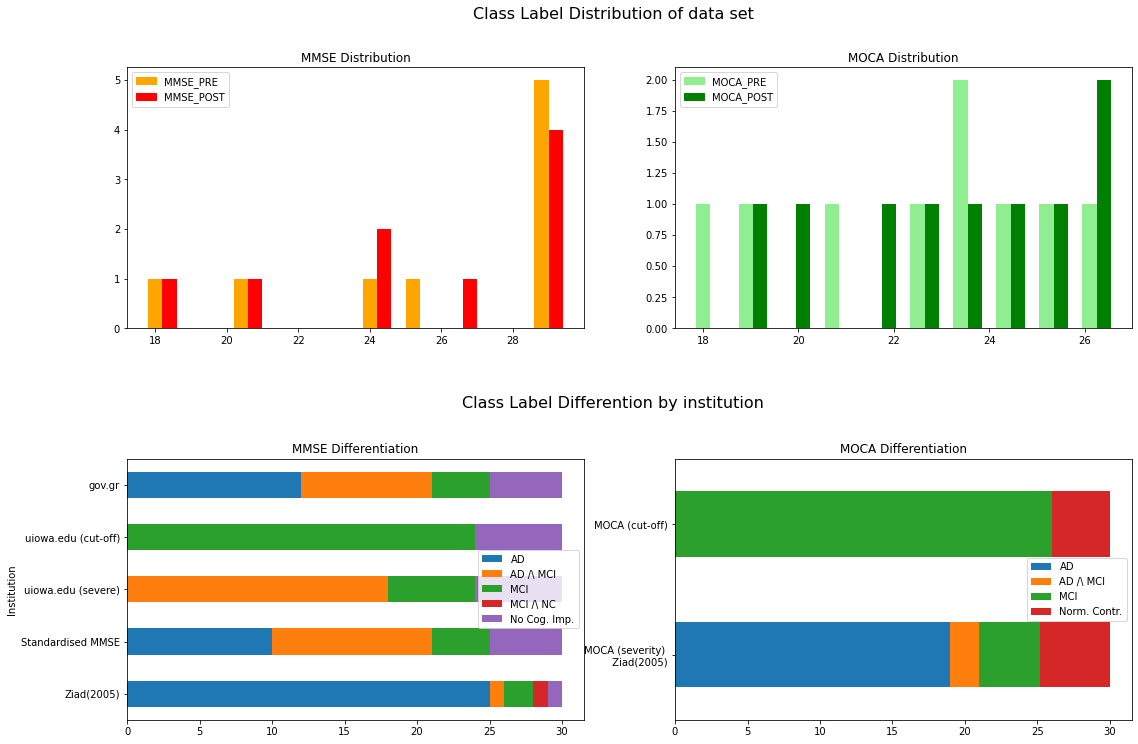

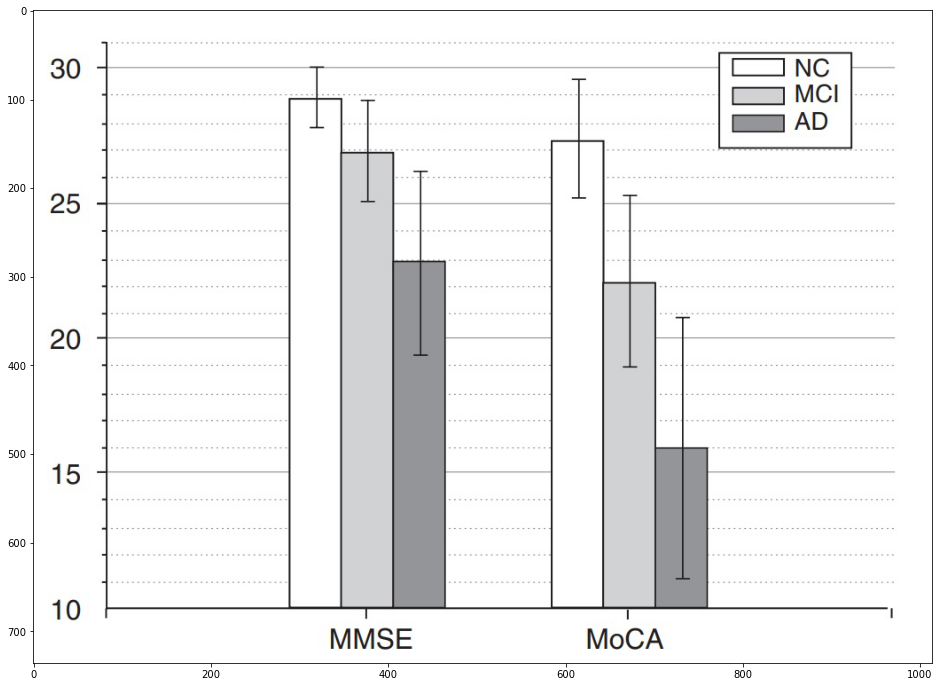

In [7]:
# inspect the distribution of potential target classes
ut.inspect_target_distribution(df)

In [8]:
# define target class (14 available, 6 moca, 6 mmse, 2 diffs)
df = db.separate_target_class(df, "moca_pre_binary_binned")

In [9]:
#'age', 'education','laptop_usage', 'smartphone_usage', 'family_med_history', 'exercising',
#'marital_status_1', 'marital_status_3', 'hypertension', 
#'total_gr_in_gs', 'total_success_rounds_in_session', 'total_win_gr_points_in_gs', 
#'avg_gr_time_in_gs','avg_gr_time_win_gr_in_gs',
#'puzzleImp', 'mazeImp', 'calcImp', 'anaklisiImp', 'calcImp', 'namingImp', 'soundImp', 'orientImp', 'langImp', 'logicImp', 'memoryImp'
#'target_class'
# sns.pairplot(df[['education', 'total_gr_in_gs', 'target_class']], hue="target_class", diag_kind="hist")

In [10]:
# Encoding.
# All of categorical are already encoded on database level.
# Here we just apply One-hot-encoding.
columns_to_one_hot_encode = ('marital_status')
df = fm.one_hot_encode_features(df, columns_to_one_hot_encode)

df shape before drop: (119, 32)
df shape after drop, before ohe: (119, 31)
df shape after ohe: (119, 33)


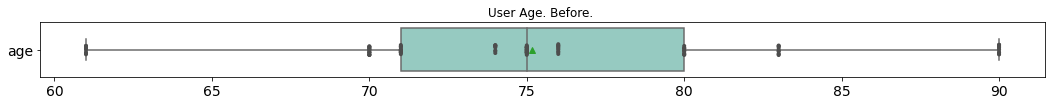

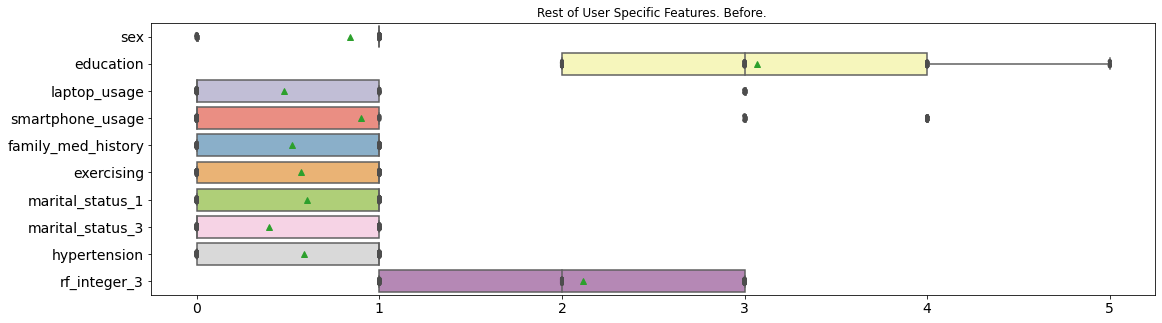

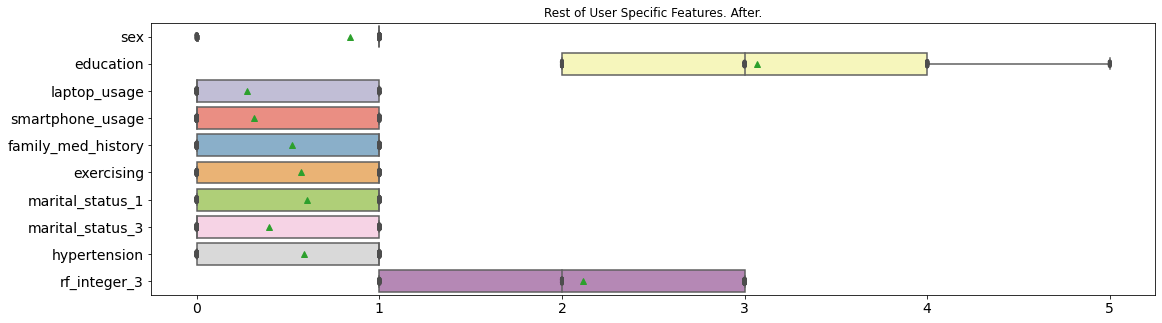

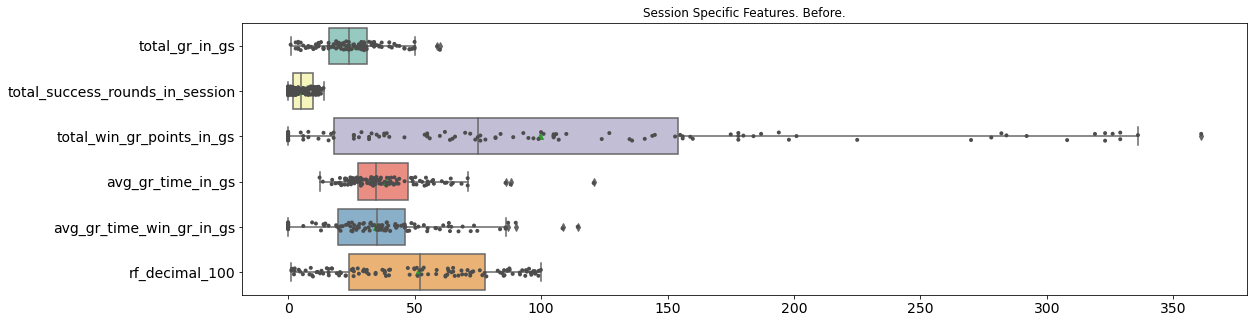

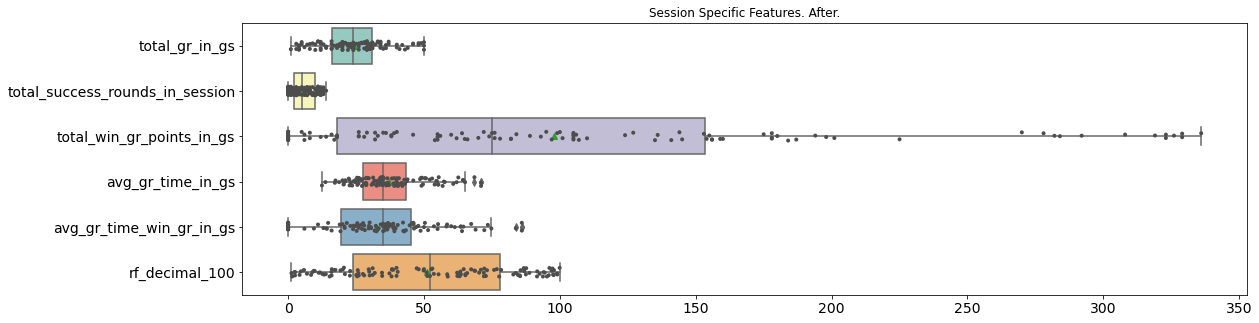

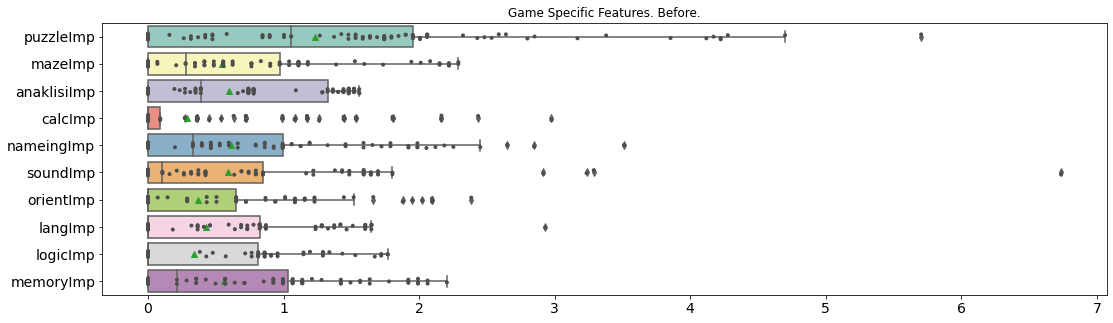

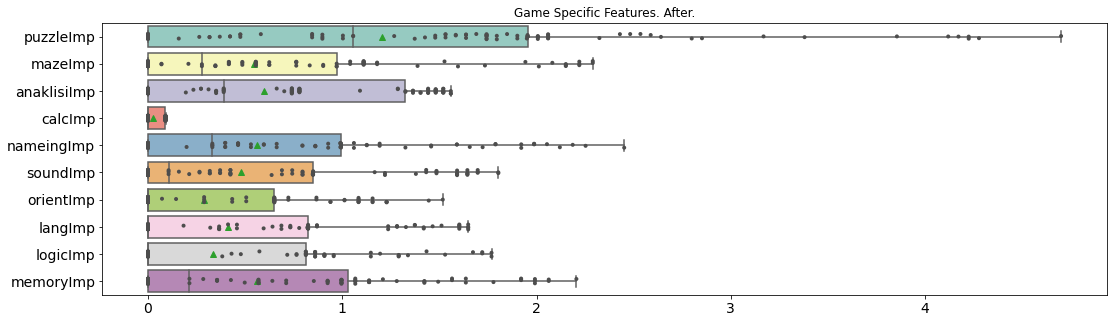

In [11]:
# handling outliers. ignoring outliers for user data.
# The whole process should avoid outliers in the first place.
df = tf.handle_outliers(df)

In [12]:
# Discretize Feauters. Before
columns_to_discretize = ['age', 'avg_gr_time_win_gr_in_gs', 'avg_gr_time_in_gs', 
                         'total_win_gr_points_in_gs', 'total_gr_in_gs', 'total_success_rounds_in_session', 'rf_decimal_100']
df[columns_to_discretize].head()

,age,avg_gr_time_win_gr_in_gs,avg_gr_time_in_gs,total_win_gr_points_in_gs,total_gr_in_gs,total_success_rounds_in_session,rf_decimal_100
gsId,,,,,,,
18245,70.0,35.0,55.4286,66.0,14.0,2.0,70.309487
76067,61.0,83.8,55.2955,105.0,44.0,5.0,52.203238
79781,83.0,51.5,38.1818,17.0,11.0,4.0,53.076168
180144,71.0,63.5,40.3043,78.0,46.0,2.0,34.618081
209758,75.0,11.0,31.2857,26.0,35.0,1.0,72.058047


In [13]:
# Discretize Feauters. After
fm.discretize_features(df, columns_to_discretize)
df[columns_to_discretize].head()

,age,avg_gr_time_win_gr_in_gs,avg_gr_time_in_gs,total_win_gr_points_in_gs,total_gr_in_gs,total_success_rounds_in_session,rf_decimal_100
gsId,,,,,,,
18245,1,3,5,2,1,2,4
76067,0,5,5,3,5,3,3
79781,5,5,3,1,0,2,3
180144,2,5,4,3,5,2,2
209758,3,1,2,1,5,1,4


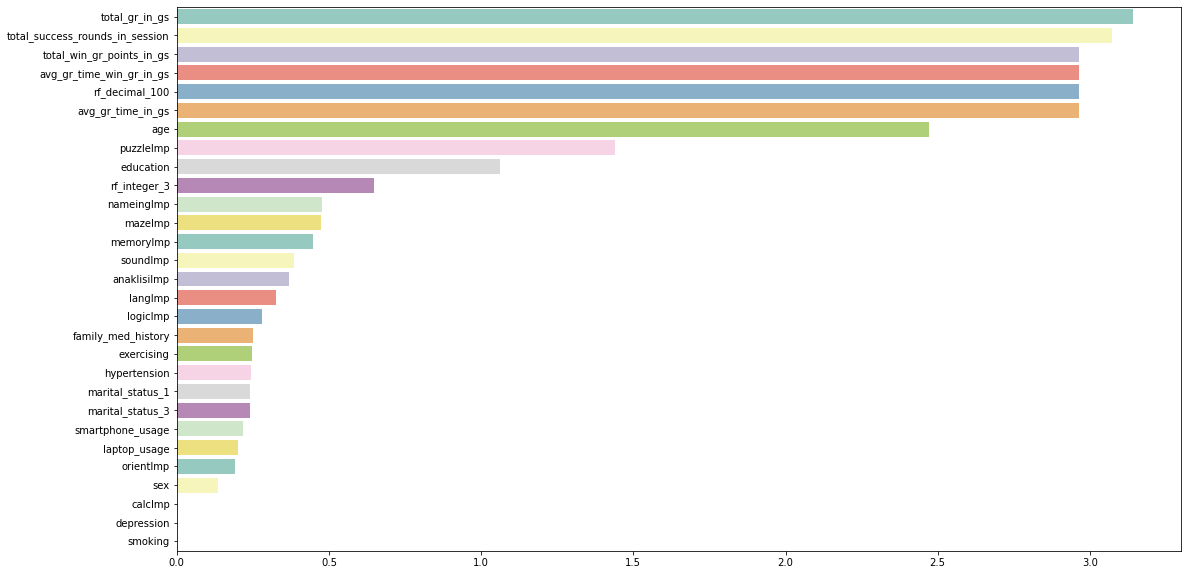

,0
total_gr_in_gs,3.143000
total_success_rounds_in_session,3.073779
total_win_gr_points_in_gs,2.963965
avg_gr_time_win_gr_in_gs,2.963965
rf_decimal_100,2.963965
avg_gr_time_in_gs,2.963965
age,2.472440
puzzleImp,1.438895
education,1.063239
rf_integer_3,0.647059


Threshold value:  0.16
Features ruled out: 
 ['sex', 'smoking', 'depression', 'calcImp']


In [14]:
# remove low variance features. 
p=0.8 # percentage of most frequent value in the distribution
df = fm.remove_low_variance_features(df, (p * (1 - p)), ddof_val=1)

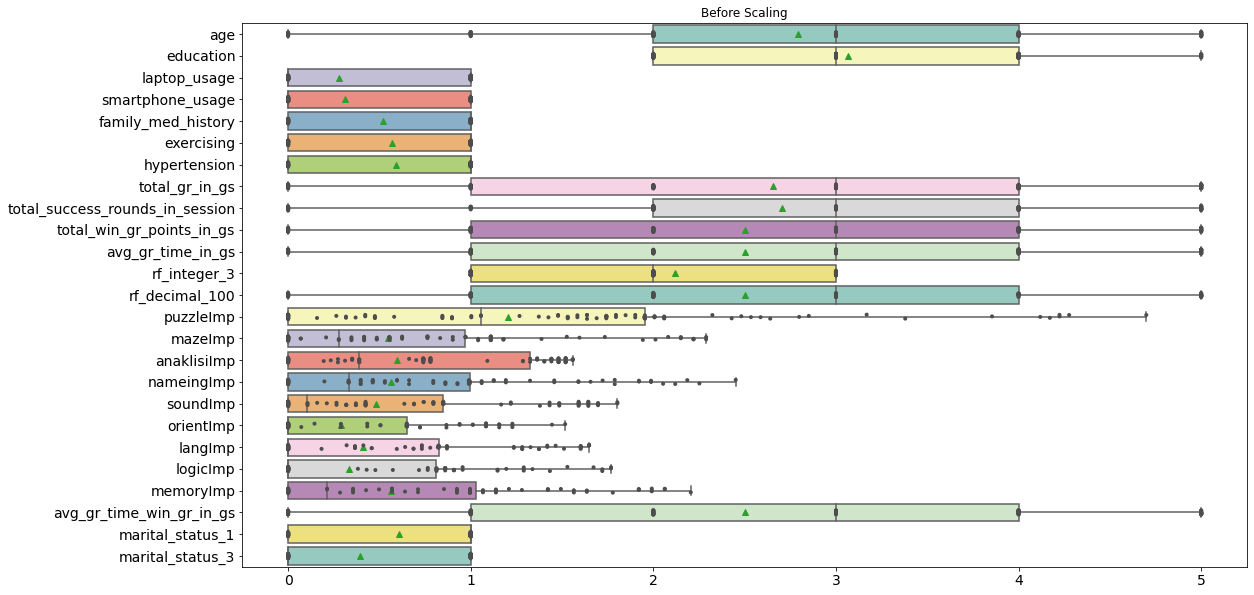

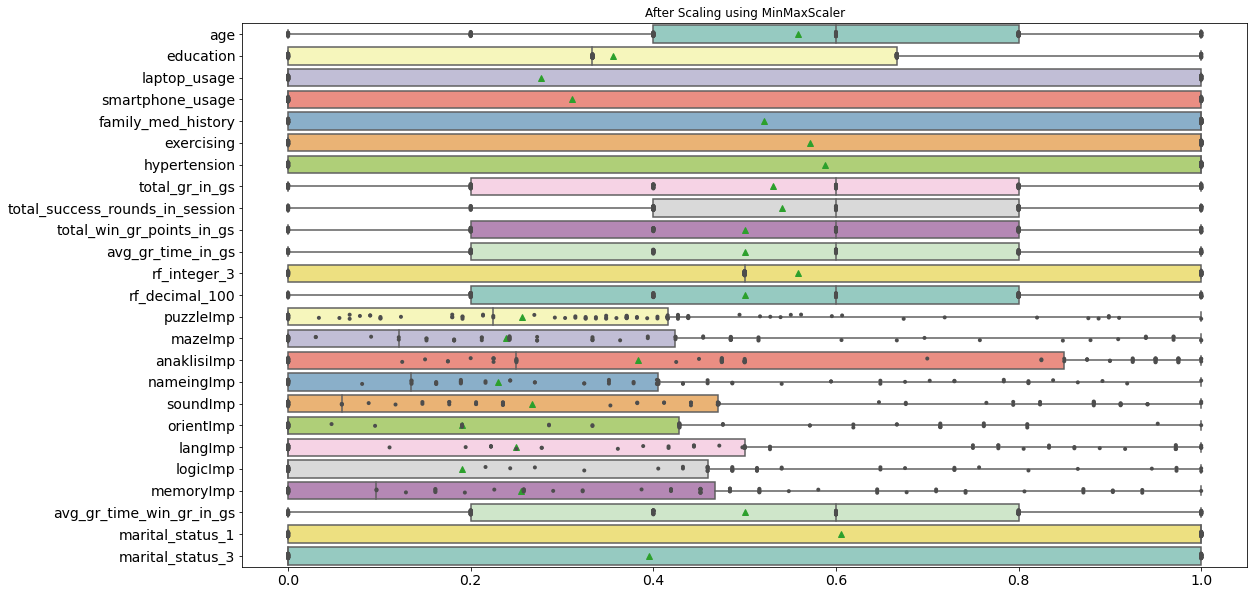

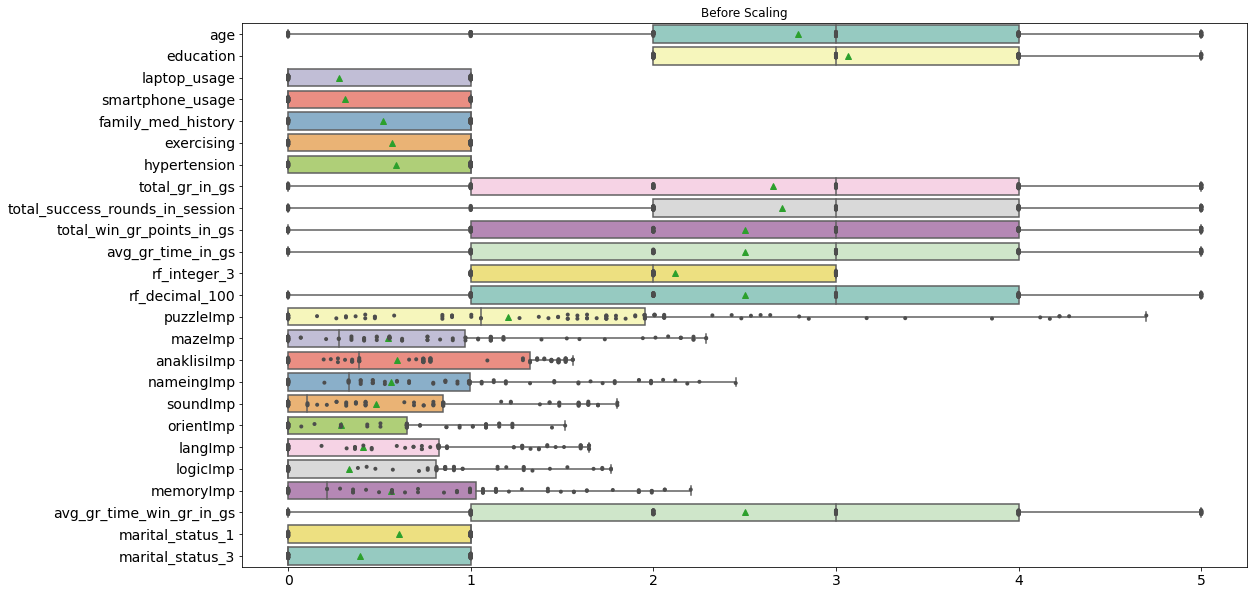

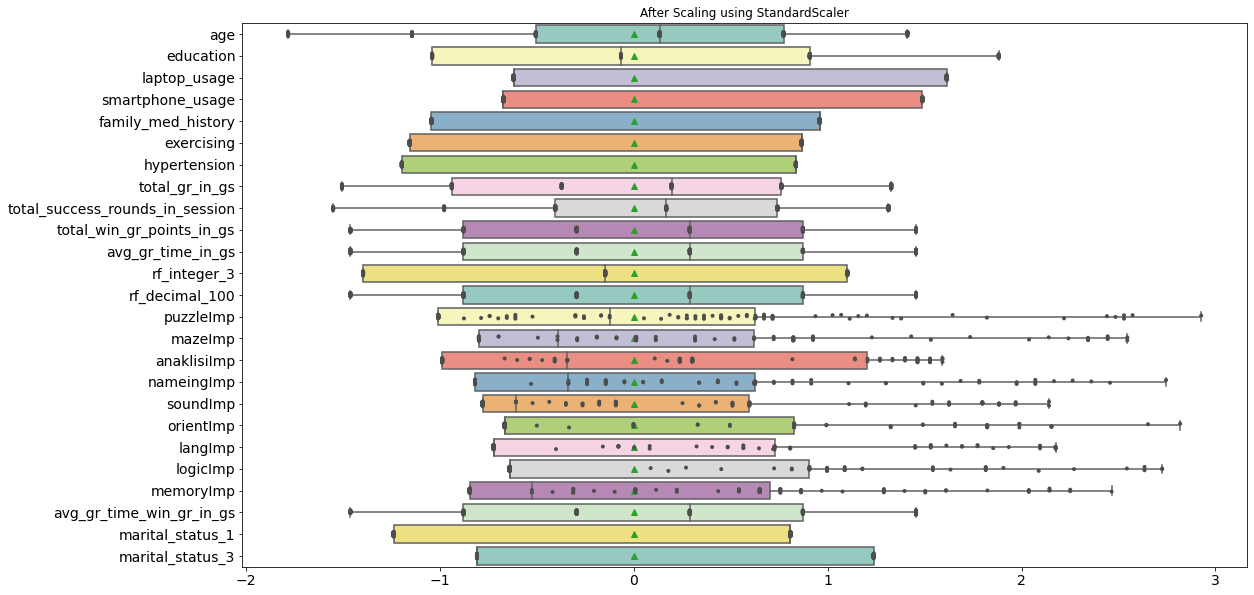

In [15]:
# scaling
columnsToIgnore = ['userId', 'gsId', 'gsStartTime', 'target_class']
df_nrm = df.copy()
df_std = df.copy()
df_nrm = tf.use_min_max(df_nrm, columnsToIgnore)
df_std = tf.use_standard_scaler(df_std, columnsToIgnore)

In [16]:
# Save the dataframe for the next EDA steps
pathFileName_nrm = 'dataframes/df_nrm.joblib'
pathFileName_std = 'dataframes/df_std.joblib'
pkl.dump(df_nrm, open(pathFileName_nrm, 'wb'))
pkl.dump(df_std, open(pathFileName_std, 'wb'))